In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img


In [ ]:
import os

#https://www.kaggle.com/datasets/gunjansanjaykadam/tumorr

def get_data_labels(data_dir):

    data_paths = []
    data_labels = []


    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)


        if os.path.isdir(class_path):

            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)


                if os.path.isfile(file_path):
                    data_paths.append(file_path)
                    data_labels.append(class_dir)

    return data_paths, data_labels

In [ ]:
SAVE = False
SEED = 111

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [ ]:
USER_PATH = r"/kaggle/input/tumorr/tumor_disease"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'




In [ ]:
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training
Number of Paths: 40
Number of Labels: 40

Testing
Number of Paths: 40
Number of Labels: 40


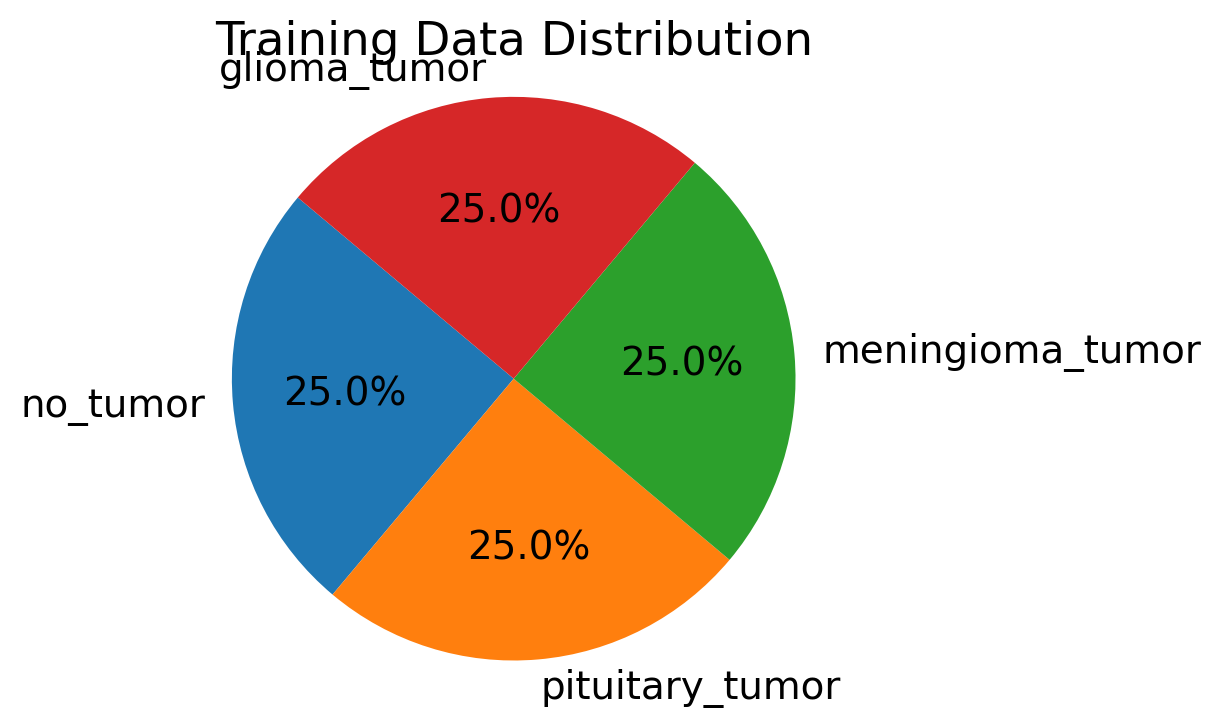

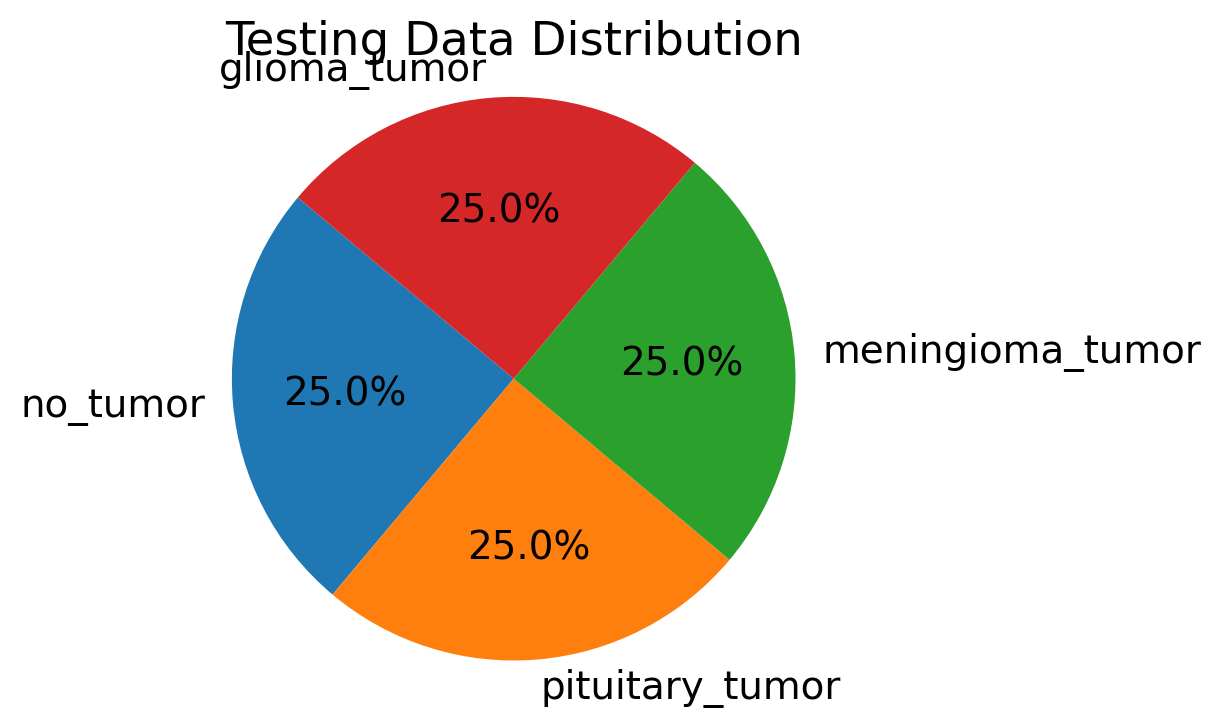

In [ ]:
import matplotlib.pyplot as plt

def plot_pie_chart(labels, title):
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1


    label_names = list(label_counts.keys())
    sizes = list(label_counts.values())

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=label_names, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_pie_chart(train_labels, 'Training Data Distribution')
plot_pie_chart(test_labels, 'Testing Data Distribution')


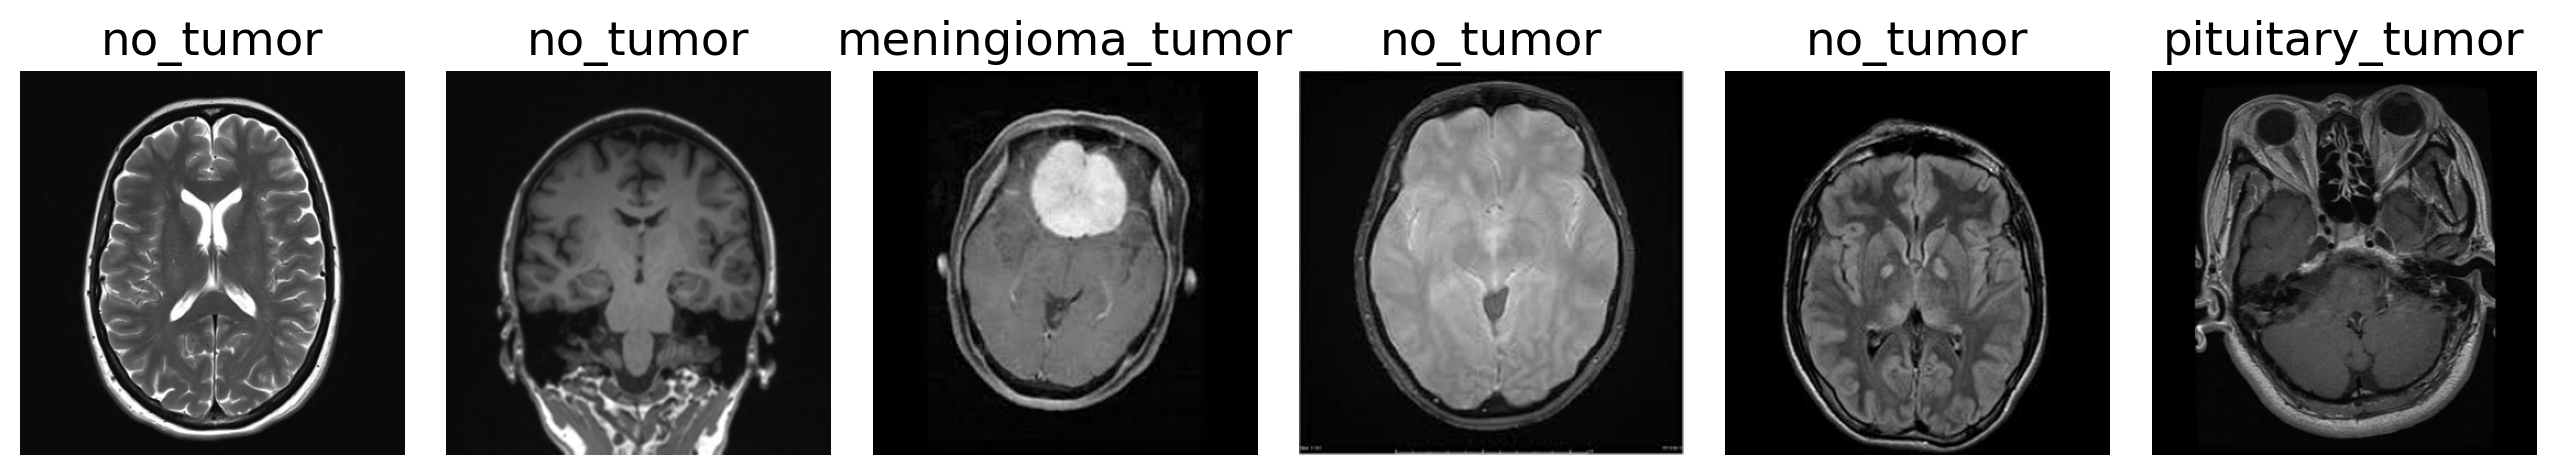

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(image_paths, image_labels, im_size=350, figsize=(13, 10), index_list=[0, 1, 2, 3, 4, 15]):

    num_images = len(index_list)

    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    if num_images == 1:
        axes = [axes]

    for ax, idx in zip(axes, index_list):
        img = Image.open(image_paths[idx])
        img = img.resize((im_size, im_size))

        ax.imshow(img)
        ax.set_title(image_labels[idx])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_paths, train_labels, im_size=350, figsize=(13, 10), index_list=[0, 1, 25, 3, 4, 15])


In [ ]:
import numpy as np
from PIL import Image

def preprocess_images(image_paths, target_size=(224, 224)):
    processed_images = []

    for path in image_paths:
        img = Image.open(path)

        img = img.resize(target_size)

        img_array = np.array(img)

        img_array = img_array / 255.0

        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,)*3, axis=-1)

        processed_images.append(img_array)

    return np.array(processed_images)

train_images = preprocess_images(train_paths, target_size=(224, 224))
test_images = preprocess_images(test_paths, target_size=(224, 224))

print(f"Processed training images shape: {train_images.shape}")
print(f"Processed testing images shape: {test_images.shape}")


Processed training images shape: (40, 224, 224, 3)
Processed testing images shape: (40, 224, 224, 3)


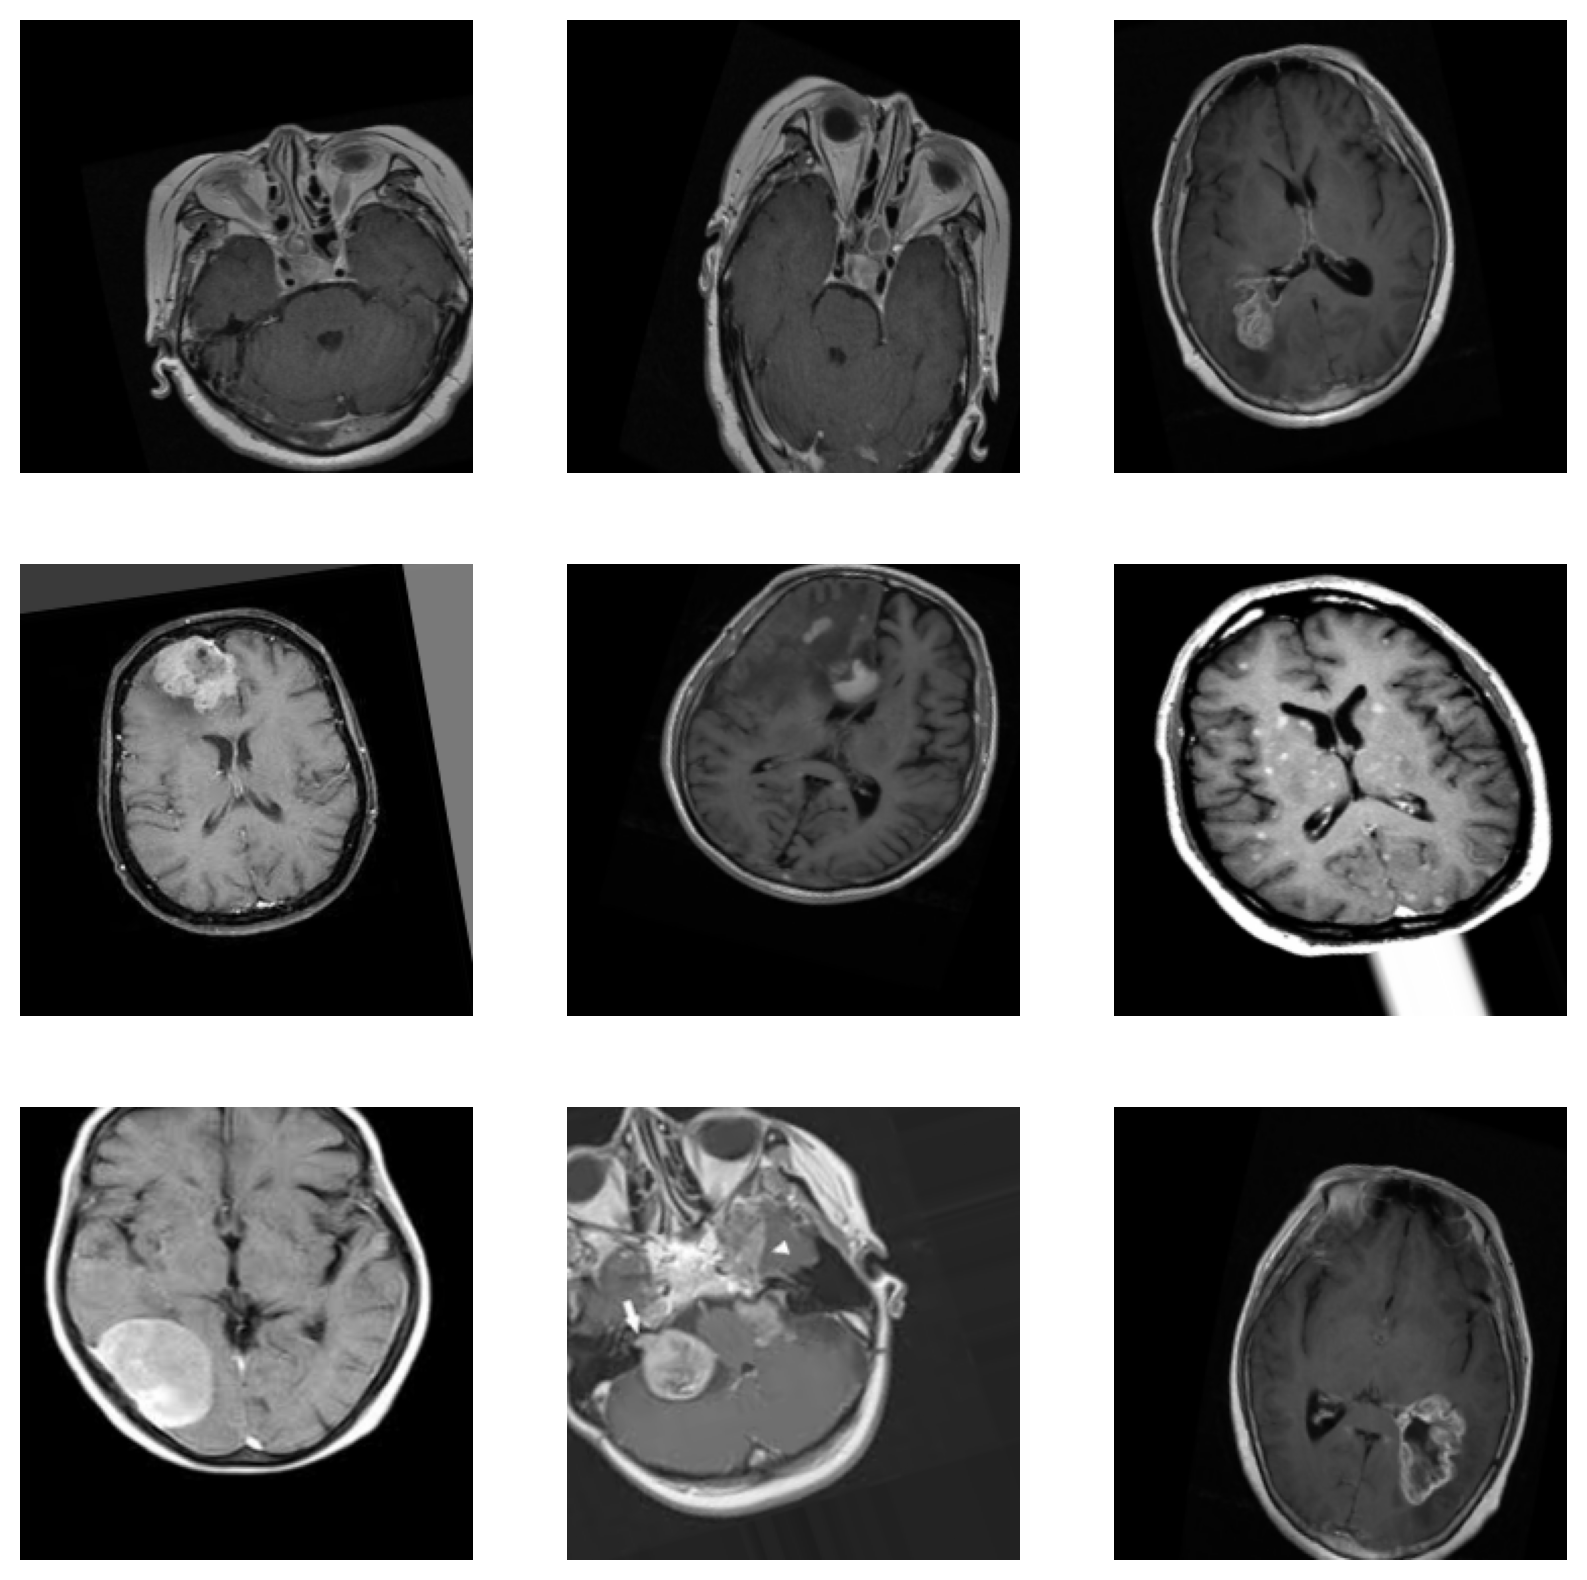

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_and_augment_images(image_paths, target_size=(224, 224), batch_size=32):

    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    path = r"/kaggle/input/tumorr/tumor_disease"
    processed_images = []
    for path in image_paths:

        img = Image.open(path)

        img = img.resize(target_size)

        img_array = np.array(img)

        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,)*3, axis=-1)

        processed_images.append(img_array)

    processed_images = np.array(processed_images)

    datagen_iter = datagen.flow(processed_images, batch_size=batch_size)

    return datagen_iter

train_aug_iter = preprocess_and_augment_images(train_paths, target_size=(224, 224), batch_size=32)

import matplotlib.pyplot as plt

augmented_images = next(train_aug_iter)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

def preprocess_and_save_augmented_images(image_paths, save_dir, target_size=(224, 224), batch_size=32, num_augmented_images=100):
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    path = r"/kaggle/input/tumorr/tumor_disease"
    processed_images = []
    for path in image_paths:
        img = Image.open(path)

        img = img.resize(target_size)
        img_array = np.array(img)

        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,)*3, axis=-1)

        processed_images.append(img_array)
    processed_images = np.array(processed_images)

    datagen_iter = datagen.flow(processed_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg')

    total_augmented_images = 0
    while total_augmented_images < num_augmented_images:
        for _ in range(batch_size):
            next(datagen_iter)
            total_augmented_images += 1
            if total_augmented_images >= num_augmented_images:
                break

    return total_augmented_images

train_paths, train_labels = get_data_labels(train_dir)
save_dir = "/kaggle/working/"
total_augmented_images = preprocess_and_save_augmented_images(train_paths, save_dir, target_size=(224, 224), batch_size=32, num_augmented_images=100)

print(f'Total original images: {len(train_paths)}')
print(f'Total augmented images saved: {total_augmented_images}')


Total original images: 40
Total augmented images saved: 100
